## Imports

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from copy import deepcopy

In [4]:
# Pretty plots
import seaborn as sns
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rc('font',family='serif', serif=['Palatino'])
sns.set(font='serif', font_scale=1.4)
sns.set_style("white", {
        "font.family": "serif",
        "font.weight": "normal",
        "font.serif": ["Times", "Palatino", "serif"],
        'axes.facecolor': 'white',
        'lines.markeredgewidth': 1})

def setup_plot():
    fig = plt.figure(dpi=100, figsize=(5.0,3.0))
    ax = plt.subplot(111)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = 15)
    ax.tick_params(direction='in')

In [5]:
from src.models import Model, LinearModel
from src.oadam import OAdam, add_weight_decay, net_to_list
from src.learners.bc import BC
from src.learners.doubil import DoubIL
from src.learners.residuil import ResiduIL

## LQG System

In [4]:
import src.lqg

In [5]:
K_star = src.lqg.solve(src.lqg.A, src.lqg.B, src.lqg.Q, src.lqg.R)
print(K_star)
def expert(s):
    if s.size == 2:
        return K_star @ s
    else:
        return s @ K_star.T

Converged with horizon 34
[[-2.57543063 -3.43994714]]


In [6]:
def learner(K, s):
    if s.size == 2:
        return K @ s
    else:
        return s @ K.T

In [7]:
denoised_expert_trajs = []
for _ in range(100):
    s_0 = np.random.normal(size=(2, 1))
    s_traj, a_traj, _ = src.lqg.rollout(s_0, expert)
    denoised_expert_trajs.append((s_traj, a_traj))

Text(0, 0.5, 'pos.')

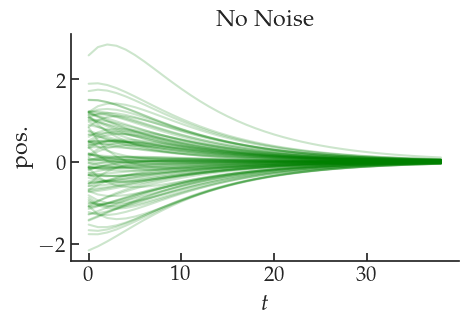

In [8]:
setup_plot()
for (pos, vel) in denoised_expert_trajs:
    plt.plot(np.arange(len(pos)), pos[:, 0], color="green", alpha=0.2)
plt.title("No Noise")
plt.xlabel("$t$")
plt.ylabel("pos.")

In [9]:
expert_trajs_1 = []
for _ in range(20):
    s_0 = np.random.normal(size=(2, 1))
    s_traj, a_traj, _ = src.lqg.noisy_rollout(s_0, expert, num_steps_cnfnd=1)
    expert_trajs_1.append((s_traj, a_traj))
expert_trajs_5 = []
for _ in range(20):
    s_0 = np.random.normal(size=(2, 1))
    s_traj, a_traj, _ = src.lqg.noisy_rollout(s_0, expert, num_steps_cnfnd=5)
    expert_trajs_5.append((s_traj, a_traj))
expert_trajs_10 = []
for _ in range(20):
    s_0 = np.random.normal(size=(2, 1))
    s_traj, a_traj, _ = src.lqg.noisy_rollout(s_0, expert, num_steps_cnfnd=10)
    expert_trajs_10.append((s_traj, a_traj))

Text(0, 0.5, 'pos.')

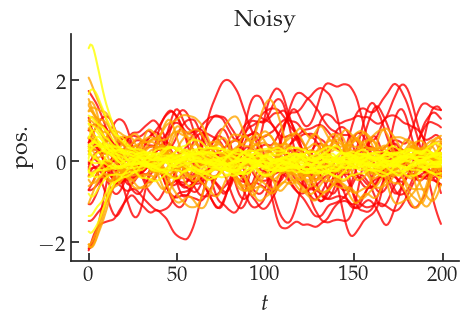

In [10]:
setup_plot()
for (pos, vel) in expert_trajs_10:
    plt.plot(np.arange(len(pos)), pos[:, 0], alpha=0.8, color="red")
for (pos, vel) in expert_trajs_5:
    plt.plot(np.arange(len(pos)), pos[:, 0], alpha=0.8, color="orange")
for (pos, vel) in expert_trajs_1:
    plt.plot(np.arange(len(pos)), pos[:, 0], alpha=0.8, color="yellow")
plt.title("Noisy")
plt.xlabel("$t$")
plt.ylabel("pos.")

In [12]:
kappas = []
Js = []
for i in range(1):
    kappas_i = []
    for num_steps_cnfnd in range(1, 16):
        expert_trajs = []
        for _ in range(1000):
            s_0 = np.random.normal(size=(2, 1))
            s_traj, a_traj, _ = src.lqg.noisy_rollout(s_0, expert, num_steps_cnfnd=num_steps_cnfnd)
            expert_trajs.append((s_traj, a_traj))
        S_past = np.concatenate([x[0][100:][:-num_steps_cnfnd] for x in expert_trajs], axis=0)
        S_curr = np.concatenate([x[0][100:][num_steps_cnfnd:] for x in expert_trajs], axis=0)
        A_curr = np.concatenate([x[1][100:][num_steps_cnfnd:] for x in expert_trajs], axis=0)

        # compute kappa
        sigma = (S_curr.T @ S_curr) / len(S_curr)
        num = np.max(np.linalg.eig(sigma)[0])
        M = (src.lqg.A + src.lqg.B @ K_star) ** num_steps_cnfnd
        V = np.mean([(M @ s.reshape(-1, 1)) @ (M @ s.reshape(-1, 1)).T for s in S_past], axis=0)
        denom = np.min(np.linalg.eig(V)[0])
        kappas_i.append(np.sqrt(num / denom))
    kappas.append(kappas_i)

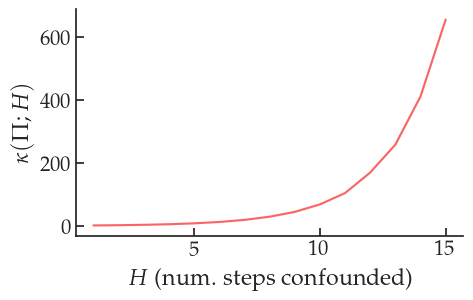

In [13]:
setup_plot()
plt.plot(list(range(1, len(kappas[0]) + 1)), np.mean(kappas, axis=0), color="#f96565")
plt.fill_between(list(range(1, len(kappas[0]) + 1)),
                 np.mean(kappas, axis=0) - (np.std(kappas, axis=0) / np.sqrt(len(kappas))),
                 np.mean(kappas, axis=0) + (np.std(kappas, axis=0) / np.sqrt(len(kappas))),
                 color = "#f96565",
                 alpha = 0.1)
plt.ylabel("$\kappa(\Pi; H)$")
plt.xlabel("$H$ (num. steps confounded)")
plt.show()
# plt.savefig("figs/length_cnfnd.pdf", bbox_inches='tight')

In [14]:
# pi_BC = BC(expert_trajs, LinearModel(2, 1), lr=3e-4)
# K_BC = [x.detach().numpy() for x in pi_BC.parameters()][0].reshape(-1)
# print('Param. MSE =', np.linalg.norm(K_star - K_BC))

In [15]:
# pi_DoubIL = DoubIL(expert_trajs, LinearModel(2, 1), src.lqg.dynamics, pi_BC=pi_BC, lr=3e-4)
# K_DoubIL = [x.detach().numpy() for x in pi_DoubIL.parameters()][0].reshape(-1)
# print('Param. MSE =', np.linalg.norm(K_star - K_DoubIL))

In [16]:
# pi_ResiduIL = ResiduIL(expert_trajs, LinearModel(2, 1), LinearModel(2, 1), lr=3e-4)
# K_ResiduIL = [x.detach().numpy() for x in pi_ResiduIL.parameters()][0].reshape(-1)
# print('Param. MSE =', np.linalg.norm(K_star - K_ResiduIL))

## LunarLander

In [11]:
import gym

In [12]:
from src.lunar_lander_env import LunarLanderContinuous
from src.lunar_lander_utils import T, dynamics, rollout, noisy_rollout, eval_policy

In [13]:
from stable_baselines3 import PPO
expert_net = PPO.load("src/experts/ll_expert_curr")
def expert(s):
    return expert_net.predict(s, deterministic=True)

In [14]:
env = LunarLanderContinuous(confounding=False, fixed_terrain=True)

In [15]:
env.reset()
denoised_expert_trajs = []
Js = []
for _ in range(25):
    s_traj, a_traj, J = rollout(expert, env)
    denoised_expert_trajs.append((s_traj, a_traj))
    Js.append(J)

In [16]:
print(Js, np.mean(Js))

[281.56056945217625, 183.16094978992027, -225.53405524331023, 215.74144604456447, 277.2899940331465, 252.62630073062337, 264.70134393092735, 185.12410619528953, 159.4740855546711, 262.88293465102413, 220.82749950344373, 297.0129191216881, 203.32498271798383, -71.67078509077206, 168.862774395249, -225.4816353309491, 276.8297474472257, 186.45110721764237, 270.7899703843593, 238.79543410190064, 274.7662089630872, 286.62092313791015, 236.0985674335465, 257.59743367822, 195.60789138916846] 186.93842856834948


In [17]:
env.reset()
expert_trajs2 = []
Js = []
for _ in range(25):
    s_traj, a_traj, J = noisy_rollout(expert, env, sigma=0.5)
    expert_trajs2.append((s_traj, a_traj))
    Js.append(J)

In [18]:
print(Js, np.mean(Js))

[-520.3092855793152, -73.8476895539458, -96.41499241215902, -421.60914517018455, -189.58838048884832, -62.64755477730111, -307.37482642541465, -533.3416418500246, -456.8970042463378, -427.92857954914746, -143.32583513560223, -398.5420958770895, -412.30488728616234, -391.2480826878447, -136.05828334896083, -327.3526263550684, -336.0234813228982, -183.99124333142078, -370.02120492961365, -521.8310020942017, -184.3043165155928, -112.30088382234291, -423.39409586719034, -232.13136711428788, -480.4007719073442] -309.727571105932


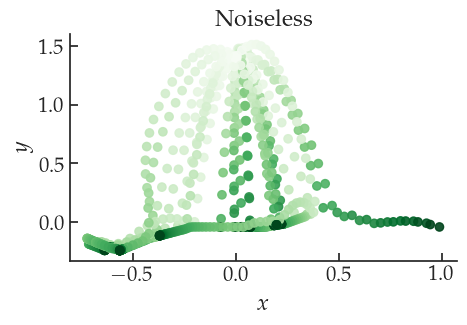

In [19]:
setup_plot()
for (s_traj, _) in denoised_expert_trajs:
    plt.scatter(s_traj[::5, 0,],
                s_traj[::5, 1],
                c=np.arange(len(s_traj[::5, 0,])),
                cmap='Greens',
                alpha=0.9)
plt.title("Noiseless")
plt.ylabel("$y$")
plt.xlabel("$x$")
plt.show()

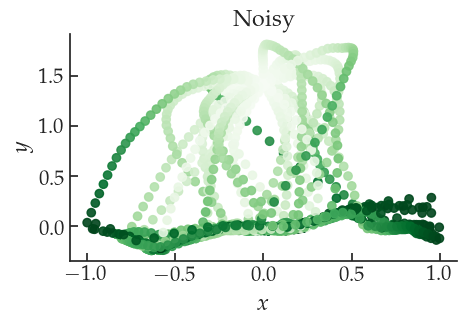

In [20]:
setup_plot()
for (s_traj, _) in expert_trajs2:
    plt.scatter(s_traj[::5, 0,],
                s_traj[::5, 1],
                c=np.arange(len(s_traj[::5, 0,])),
                cmap='Greens',
                alpha=0.9)
plt.title("Noisy")
plt.ylabel("$y$")
plt.xlabel("$x$")
plt.show()

In [21]:
# Generate test set
env.reset()
denoised_test = []
Js = []
for _ in range(100):
    s_traj, _, J = rollout(expert, env)
    Js.append(J)
    denoised_test.append((s_traj, expert(s_traj)[0]))
print(np.mean(Js))
np.savez("data/denoised_test_ll", denoised_test)

171.45897797075256


In [22]:
noisy_test = []
Js = []
for _ in range(100):
    s_traj, _, J = noisy_rollout(expert, env, sigma=0.5)
    print(J)
    Js.append(J)
    noisy_test.append((s_traj, expert(s_traj)[0]))
print(np.mean(Js))
np.savez("data/noisy_test_ll", noisy_test)

-334.66558742698726
-264.60221278315055
-500.3104122497136
-487.7655495392645
-779.0935584167206
-453.19649023188117
-171.23003261493164
-531.4588895620764
-233.569144715222
-276.04343204370764
-322.07929739682277
-494.42100410935683
-379.6448635957442
-398.9790155682253
-395.70145933934356
-313.43433509097497
-415.68189970923277
-424.05838584915364
-378.07939551235154
-163.11388316833307
-473.96961099652
-200.88650427775838
-544.8739893035847
-377.8786341534722
-182.4079901772838
-444.1361954857069
-372.6107259411204
-70.51977225880901
-400.09196172810863
-368.2717374206155
-448.22147247395236
-210.50498732105063
-185.7696100632197
-257.37597577884776
-354.1196069700924
-552.1792197038818
-68.13693817620224
-140.27525984372753
-162.06843689232448
-451.3715873273161
-648.3159592985438
-193.60711439014955
-414.52935984005984
-576.1766413900687
-421.75873921493
-415.13441632103854
-358.88102506850515
-151.5744312917693
-86.19204056705453
-451.1982220100582
-55.17363012914676
-131.9653358

In [28]:
# Generate training sets
start = 0
while True:
    try:
        for i in range(start, 5):
            for size in [10, 20, 30, 40, 50]:
                print(i, size)
                trajs = []
                for _ in range(size):
                    s_traj, a_traj, _ = noisy_rollout(expert, env, sigma=0.5)
                    trajs.append((s_traj, a_traj))
                np.savez("data/train_{0}_{1}_ll".format(size, i), trajs)
            start = i + 1
    except ValueError:
        pass
    else:
        break

0 10
0 20
0 30
0 40
0 50
1 10
1 20
1 30
1 40
1 50
2 10
2 20
2 30
2 40
2 50
3 10
3 20
3 30
3 40
3 50
4 10
4 20
4 30
4 40
4 50


In [29]:
denoised_test = np.load("./data/denoised_test_ll.npz", allow_pickle=True)["arr_0"]
noisy_test = np.load("./data/noisy_test_ll.npz", allow_pickle=True)["arr_0"]

In [30]:
def mse(pi, dataset):
    total = 0
    for (s_traj, a_traj) in dataset:
        total += np.linalg.norm(pi(s_traj) - a_traj)
    return total / len(dataset)

In [31]:
bc_mse_noisy = []
bc_mse_denoised = []
bc_J_noisy = []
bc_J_denoised = []

doubil_mse_noisy = []
doubil_mse_denoised = []
doubil_J_noisy = []
doubil_J_denoised = []

residuil_mse_noisy = []
residuil_mse_denoised = []
residuil_J_noisy = []
residuil_J_denoised = []

In [32]:
for i in range(0, 5):
    bc_mse_noisy_i = []
    bc_mse_denoised_i = []
    bc_J_noisy_i = []
    bc_J_denoised_i = []

    doubil_mse_noisy_i = []
    doubil_mse_denoised_i = []
    doubil_J_noisy_i = []
    doubil_J_denoised_i = []

    residuil_mse_noisy_i = []
    residuil_mse_denoised_i = []
    residuil_J_noisy_i = []
    residuil_J_denoised_i = []
    
    for size in [10, 20, 30, 40, 50]:
        expert_trajs = np.load("./data/train_{0}_{1}_ll.npz".format(size, i), allow_pickle=True)["arr_0"]
    
        pi_BC = BC(expert_trajs, Model(env.observation_space.shape[0], env.action_space.shape[0]))
        bc_mse_noisy_i.append(mse(lambda s: pi_BC(torch.from_numpy(s).float()).detach().numpy(), noisy_test))
        bc_mse_denoised_i.append(mse(lambda s: pi_BC(torch.from_numpy(s).float()).detach().numpy(), denoised_test))
        bc_J_noisy_i.append(eval_policy(lambda s: pi_BC(torch.from_numpy(s).float()).detach().numpy(), env, noisy=True))
        bc_J_denoised_i.append(eval_policy(lambda s: pi_BC(torch.from_numpy(s).float()).detach().numpy(), env, noisy=False))
        print('BC',
              size,
              bc_mse_noisy_i[-1],
              bc_mse_denoised_i[-1],
              bc_J_noisy_i[-1],
              bc_J_denoised_i[-1])
    
        
        pi_DoubIL = DoubIL(expert_trajs,
                   Model(env.observation_space.shape[0], env.action_space.shape[0]),
                   lambda a, b: dynamics(a, b, env), pi_BC=pi_BC, nsamp=4)
        doubil_mse_noisy_i.append(mse(lambda s: pi_DoubIL(torch.from_numpy(s).float()).detach().numpy(), noisy_test))
        doubil_mse_denoised_i.append(mse(lambda s: pi_DoubIL(torch.from_numpy(s).float()).detach().numpy(), denoised_test))
        doubil_J_noisy_i.append(eval_policy(lambda s: pi_DoubIL(torch.from_numpy(s).float()).detach().numpy(), env, noisy=True))
        doubil_J_denoised_i.append(eval_policy(lambda s: pi_DoubIL(torch.from_numpy(s).float()).detach().numpy(), env, noisy=False))
        print('doubil',
              size,
              doubil_mse_noisy_i[-1],
              doubil_mse_denoised_i[-1],
              doubil_J_noisy_i[-1],
              doubil_J_denoised_i[-1])
        
        pi_ResiduIL = ResiduIL(expert_trajs,
                       Model(env.observation_space.shape[0], env.action_space.shape[0]),
                       Model(env.observation_space.shape[0], env.action_space.shape[0]))
        residuil_mse_noisy_i.append(mse(lambda s: pi_ResiduIL(torch.from_numpy(s).float()).detach().numpy(), noisy_test))
        residuil_mse_denoised_i.append(mse(lambda s: pi_ResiduIL(torch.from_numpy(s).float()).detach().numpy(), denoised_test))
        residuil_J_noisy_i.append(eval_policy(lambda s: pi_ResiduIL(torch.from_numpy(s).float()).detach().numpy(), env, noisy=True))
        residuil_J_denoised_i.append(eval_policy(lambda s: pi_ResiduIL(torch.from_numpy(s).float()).detach().numpy(), env, noisy=False))
        print('residuil',
              size,
              residuil_mse_noisy_i[-1],
              residuil_mse_denoised_i[-1],
              residuil_J_noisy_i[-1],
              residuil_J_denoised_i[-1])

    
    bc_mse_noisy.append(bc_mse_noisy_i)
    bc_mse_denoised.append(bc_mse_denoised_i)
    bc_J_noisy.append(bc_J_noisy_i)
    bc_J_denoised.append(bc_J_denoised_i)
    np.savez("data/bc_mse_noisy_ll", bc_mse_noisy)
    np.savez("data/bc_mse_denoised_ll", bc_mse_denoised)
    np.savez("data/bc_J_noisy_ll", bc_J_noisy)
    np.savez("data/bc_J_denoised_ll", bc_J_denoised)
    
    doubil_mse_noisy.append(doubil_mse_noisy_i)
    doubil_mse_denoised.append(doubil_mse_denoised_i)
    doubil_J_noisy.append(doubil_J_noisy_i)
    doubil_J_denoised.append(doubil_J_denoised_i)
    np.savez("data/doubil_mse_noisy_ll", doubil_mse_noisy)
    np.savez("data/doubil_mse_denoised_ll", doubil_mse_denoised)
    np.savez("data/doubil_J_noisy_ll", doubil_J_noisy)
    np.savez("data/doubil_J_denoised_ll", doubil_J_denoised)
    
    residuil_mse_noisy.append(residuil_mse_noisy_i)
    residuil_mse_denoised.append(residuil_mse_denoised_i)
    residuil_J_noisy.append(residuil_J_noisy_i)
    residuil_J_denoised.append(residuil_J_denoised_i)
    np.savez("data/residuil_mse_noisy_ll", residuil_mse_noisy)
    np.savez("data/residuil_mse_denoised_ll", residuil_mse_denoised)
    np.savez("data/residuil_J_noisy_ll", residuil_J_noisy)
    np.savez("data/residuil_J_denoised_ll", residuil_J_denoised)

BC Data (5096, 6) (5096, 2)
BC 10 80.64789491653443 86.99232395172119 -287.5737810383182 -315.19477915800275
Done w/ BC
IV Data (5086, 6) (5086, 2)
doubil 10 54.292807493209835 28.474200649261476 -287.853256505408 100.66681445248351
residuil 10 30.802563743591307 21.09373246192932 -292.96147427206796 154.19996357688035
BC Data (10670, 6) (10670, 2)
BC 20 54.94138997077942 29.261682901382446 -340.97380945991455 191.82960489079488
Done w/ BC
IV Data (10650, 6) (10650, 2)
doubil 20 33.25550392150879 18.63644082069397 -337.56055569426223 124.4749883108848
residuil 20 23.75853690624237 13.127983179092407 -265.82009896022356 147.66157243838114
BC Data (14044, 6) (14044, 2)
BC 30 25.729172010421753 17.712787199020386 -339.75029236078774 142.87329799426828
Done w/ BC
IV Data (14014, 6) (14014, 2)
doubil 30 17.243033804893493 14.562159109115601 -340.1098254367365 128.21104688116134
residuil 30 11.70471034526825 10.004408893585206 -422.2689666230735 131.30348164192878
BC Data (17808, 6) (17808, 

KeyboardInterrupt: 

## Confounding Test Figure

In [18]:
import matplotlib.image as image
im = image.imread("./figs/ufo.png")

In [30]:
# expert_trajs = np.load("./data/train_{0}_{1}.npz".format(20, 3), allow_pickle=True)["arr_0"]

In [31]:
# pi_ResiduIL = ResiduIL(expert_trajs,
#                        Model(env.observation_space.shape[0], env.action_space.shape[0]),
#                        Model(env.observation_space.shape[0], env.action_space.shape[0]))

In [32]:
# pi_BC = BC(expert_trajs, Model(env.observation_space.shape[0], env.action_space.shape[0]))

BC Data (3360, 6) (3360, 2)


In [48]:
env.reset()
expert_trajs2 = []
for _ in range(25):
    s_traj, a_traj, _ = noisy_rollout(lambda s: expert_net.predict(s, deterministic=True), env)
    expert_trajs2.append((s_traj, a_traj))

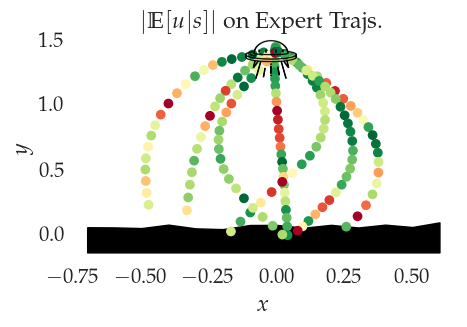

In [65]:
setup_plot()
for (s_traj, _) in expert_trajs2[0:7]:
    bc_preds = pi_BC(torch.from_numpy(s_traj).float()).detach().numpy()
    iv_preds = pi_ResiduIL(torch.from_numpy(s_traj).float()).detach().numpy()
    confounding = np.linalg.norm(bc_preds - iv_preds, axis=1)
    plt.scatter(s_traj[::5, 0,],
                s_traj[::5, 1],
                c=-confounding[::5],
                cmap='RdYlGn',
                alpha=1.0)

plt.fill_between(np.arange(-0.7, 0.7, 0.1),
                 np.arange(-0.7, 0.7, 0.1) * 0 - 0.15,
                 np.arange(-0.7, 0.7, 0.1) * 0 + 0.05 + 0.02 * np.random.normal(size=(len(np.arange(-0.7, 0.7, 0.1)))),
                 color = "black",
                 alpha = 1.0,
                 zorder=-1)

xrng=plt.xlim()
yrng=plt.ylim()
scale=.2 
plt.imshow(im,aspect='auto',extent=(xrng[0] + 0.6 ,xrng[0] + scale*(xrng[1]-xrng[0]) + 0.6, yrng[0] + 1.35, yrng[0] + scale*(yrng[1]-yrng[0]) + 1.45 ), zorder=1)
plt.xlim(xrng)
plt.ylim(yrng)

plt.title("$|\mathbb{E}[u|s]|$ on Expert Trajs.")
plt.ylabel("$y$")
plt.xlabel("$x$")
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().tick_params(bottom=False, left=False)
plt.savefig("figs/test.pdf", bbox_inches='tight')